**План работы над дипломом:**

1. Сделать и описать физическую модель задачи
2. Реализовать грубую модель в коде
3. Получить результаты вычислений по грубой модели
4. Улучшить модель
5. Получить результаты обновленной модели

Фоновая задача: найти статьи по теме диплома

In [468]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps
from tqdm import tqdm

In [469]:
V_CUT = 4.8
N_V = 20
T_1 = 1
T_2 = 2
X_MAX = 25
Y_MAX = 20
CHIP_X = 10
CHIP_DY = 1
CHIP_DX = 5
U = 0.01
N_X = 100
N_Y = 100

H_X = X_MAX / N_X
H_Y = Y_MAX / N_Y

TAU = min(H_X, H_Y) / (2*V_CUT)

In [470]:
class CollisionsGrid:
    def __init__(self, num_col=10000, v_cut=V_CUT):
        self.v_cut = v_cut
        self.num_col = num_col
        
        self.col_grid = self.set_col_grid()
        self.teta = 2 * np.arccos(self.col_grid[:, 6])
        self.ksi_update, self.ksi1_update = self.create_updated_velocities()
        
        assert np.all(((self.ksi_update**2).sum(axis=1) + 
                       (self.ksi1_update**2).sum(axis=1) - 
                       (self.col_grid[:, :6]**2).sum(axis=1)) < 10**(-9))
    
    def set_col_grid(self) -> np.ndarray:
        """
        function that create initial grid with 2 velocities, b and eps paameters
        :return: col_grid (num_col, 8)
        """
        grid = sps.uniform.rvs(size=(self.num_col, 8))
        grid[:, :6] = 2 * self.v_cut * grid[:, :6] - self.v_cut
        grid[:, 7] *= 2 * np.pi
        return grid
    
    def create_updated_velocities(self) -> (np.ndarray, np.ndarray):
        """
        Creating new velocities after collision
        :return: ksi_update, ksi1_update - two np.ndarray (num_col, 3)
        """
        g = self.col_grid[:, 3:6] - self.col_grid[:, :3]
        
        #g_1 = np.zeros_like(g)
        
        # Обновление массива g по формулам 1.12:
        indexes_0 = (g[:, 0] == 0) & (g[:, 1] == 0)
        indexes_1 = (g[:, 0] != 0) | (g[:, 1] != 0)
        g[indexes_0] = self.update_g_typeb(g[indexes_0], indexes_0)
        g[indexes_1] = self.update_g_typea(g[indexes_1], indexes_1)
                
        ksi_update = (self.col_grid[:, 3:6] + self.col_grid[:, :3] - g) / 2
        ksi1_update = (self.col_grid[:, 3:6] + self.col_grid[:, :3] + g) / 2
        
        return ksi_update, ksi1_update
    
    def update_g_typea(self, g: np.ndarray, indexes: np.ndarray) -> np.ndarray:
        """
        Updating relative velocities in regular case
        :param g: np.ndarray (sum(indexes), 3) - relative velocities
        :param indexes: np.ndarray - (num_col,) - bool matrix with regular cases
        :return: updated g - np.ndarray (sum(indexes), 3)
        """
        g_abs = np.sqrt((g**2).sum(axis=1))
        g_xy = np.sqrt((g[:, :2]**2).sum(axis=1))
        teta = self.teta[indexes]
        eps = self.col_grid[:, 7]
        
        g_1 = np.zeros_like(g)
        
        g_1[:, 0] = (g[:, 0]*np.cos(teta) - g[:, 0]*g[:, 2]*np.cos(eps)*np.sin(teta)/g_xy + 
                   g_abs*g[:, 1]*np.sin(teta)*np.sin(eps)/g_xy) 
        g_1[:, 1] = (g[:, 1]*np.cos(teta) - g[:, 1]*g[:, 2]*np.cos(eps)*np.sin(teta)/g_xy - 
                   g_abs*g[:, 0]*np.sin(teta)*np.sin(eps)/g_xy)
        g_1[:, 2] = g[:, 2]*np.cos(teta) + g_xy*np.cos(eps)*np.sin(teta)
        
        return g_1
    
    def update_g_typeb(self, g, indexes):
        """
        Updating relative velocities in irregular case
        :param g: np.ndarray (sum(indexes), 3) - relative velocities
        :param indexes: np.ndarray - (num_col,) - bool matrix with irregular cases
        :return: updated g - np.ndarray (sum(indexes), 3)
        """
        g_abs = (g**2).sum(axis=1)
        teta = self.teta[indexes]
        
        g_1 = np.zeros_like(g)
        
        g_1[:, 0] = g_abs * np.sin(self.col_grid[indexes, 7]) * np.sin(teta)
        g_1[:, 1] = g_abs * np.cos(self.col_grid[indexes, 7]) * np.sin(teta)
        g_1[:, 2] = g_abs * np.cos(teta)
        return g_1

In [472]:
class SimpleF:
    def __init__(self, v_cut=V_CUT, n_v = N_V):
        self.v_cut = v_cut
        self.v_1 = np.linspace(-self.v_cut, self.v_cut, n_v)
        
        self.v_grid = np.array(np.meshgrid(self.v_1, self.v_1, self.v_1)).T
        
        self.f = self.set_initial_data()
    
    def set_initial_data(self):
        net = np.ones((N_X, N_Y)).reshape(N_X, N_Y, 1, 1, 1)

        f_v_1 = np.exp(-((self.v_grid-U)**2).sum(axis=3)/(2*T_1))
        f = net * f_v_1 / f_v_1.sum()
        
        f[N_X*CHIP_X//X_MAX:N_X*(CHIP_X+CHIP_DX)//X_MAX, :N_Y*CHIP_DY//Y_MAX, :, :, :] = 0  # Чип
        
        f_v_2 = np.exp(-((self.v_grid-U)**2).sum(axis=3)/(2*T_2))
        f[N_X*CHIP_X//X_MAX-1, :N_Y*CHIP_DY//Y_MAX, :, :, :] = f_v_2 / f_v_2.sum()
        f[N_X*(CHIP_X+CHIP_DX)//X_MAX, :N_Y*CHIP_DY//Y_MAX, :, :, :] = f_v_2 / f_v_2.sum()
        f[N_X*CHIP_X//X_MAX:N_X*(CHIP_X+CHIP_DX)//X_MAX, N_Y*CHIP_DY//Y_MAX, :, :, :] = f_v_2 / f_v_2.sum()
        
        return f
    
    def update_data(self, new_data):
        self.f = new_data
    
    def show_state(self, name="n"):
        x_grid = np.linspace(0, X_MAX, N_X)
        y_grid = np.linspace(0, Y_MAX, N_Y)
        if name == "T":
            n = self.f.sum(axis=(2, 3, 4))
            content = (self.f * (self.v_grid**2).sum(axis=3)).sum(axis=(2, 3, 4)) / (3 * n)
        else:
            content = self.f.sum(axis=(2, 3, 4))
        plt.contourf(x_grid, y_grid, content.T, extend='both')
        #print(content[0, 0], content[50, 25])
        return content
    
    def compute_n(self, x_start, x_stop, y_start, y_stop):
        return self.f.sum(axis=(2, 3, 4))[x_start:x_stop, y_start:y_stop]
    
    def compute_T(self, x_start, x_stop, y_start, y_stop):
        n = self.f.sum(axis=(2, 3, 4))[x_start:x_stop, y_start:y_stop]
        return ((self.f * (self.v_grid**2).sum(axis=3)).sum(axis=(2, 3, 4)) / 3)[x_start:x_stop, y_start:y_stop] / n
    
    def compute_q(self, x, y):
        pass
    
    def compute_v(self, x, y):
        pass

In [440]:
class SimpleIdealSolver:
    def __init__(self, tau=TAU):
        self.tau = tau
        self.f = SimpleF()
    
    def make_timestep(self, t):
        ihalf = int(N_V/2)
        
        # k > 0
        delta_x_left = self.f.f[1:, :, ihalf:, :, :] - self.f.f[:-1, :, ihalf:, :, :]
        k_x_left = (self.f.v_1[ihalf:]*self.tau/H_X).reshape(1, 1, -1, 1, 1)
        if t % 2 == 0:
            delta_y_left = self.f.f[:, 1:, :, ihalf:, :] - self.f.f[:, :-1, :, ihalf:, :]
            k_y_left = (self.f.v_1[ihalf:]*self.tau/H_Y).reshape(1, 1, 1, -1, 1)
        
        # k < 0
        delta_x_right = self.f.f[1:, :, :ihalf, :, :] - self.f.f[:-1, :, :ihalf, :, :]
        k_x_right = (self.f.v_1[:ihalf]*self.tau/H_X).reshape(1, 1, -1, 1, 1)
        if t % 2 == 0:
            delta_y_right = self.f.f[:, 1:, :, :ihalf, :] - self.f.f[:, :-1, :, :ihalf, :]
            k_y_right = (self.f.v_1[:ihalf]*self.tau/H_Y).reshape(1, 1, 1, -1, 1)
        
        new_f = np.copy(self.f.f)
        
        
        new_f[1:, :, ihalf:, :, :] -= k_x_left*delta_x_left
        new_f[:-1, :, :ihalf, :, :] -= k_x_right*delta_x_right
        
        if t % 2 == 0:
            new_f[:, 1:, :, ihalf:, :] -= k_y_left*delta_y_left
            new_f[:, :-1, :, :ihalf, :] -= k_y_right*delta_y_right
        
        #Границы:
        #Чип:
        icxl, icxr = N_X*CHIP_X//X_MAX, N_X*(CHIP_X+CHIP_DX)//X_MAX
        icy = N_Y*CHIP_DY//Y_MAX
        new_f[icxl:icxr, :icy, :, :, :] = 0
        
        
        f_v_2 = np.exp(-(self.f.v_grid**2).sum(axis=3)/(2*T_2))
        v_abs = np.abs(self.f.v_1)
        
        # Левая граница:
        nom_h = (v_abs[ihalf:].reshape(1, -1, 1, 1)*self.f.f[icxl-1, :icy+1, ihalf:, :, :]).sum(axis=1)
        denom_h = (v_abs[:ihalf].reshape(-1, 1, 1)*f_v_2[:ihalf, :, :]).sum(axis=0)
        new_f[icxl-1, :icy+1, :ihalf, :, :] = (f_v_2[:ihalf, :, :] * nom_h.reshape(-1, 1, N_V, N_V) / denom_h)
        #print(self.f.compute_T(icxl-1, icxl, 0, icy))
        
        # Правая граница:
        nom_h = (v_abs[:ihalf].reshape(1, -1, 1, 1)*self.f.f[icxr, :icy+1, :ihalf, :, :]).sum(axis=1)
        #denom_h = (v_abs[ihalf:].reshape(-1, 1, 1)*f_v_2[ihalf:, :, :]).sum(axis=0)
        new_f[icxr, :icy+1, ihalf:, :, :] = f_v_2[ihalf:, :, :] * nom_h.reshape(-1, 1, N_V, N_V) / denom_h
        #print(self.f.compute_T(icxr, icxr+1, 0, icy))
        
        # Крышка
        #print(self.f.f[icxl:icxr, icy, :, :ihalf, :].shape)
        nom_h = (v_abs[:ihalf].reshape(1, 1, -1, 1)*self.f.f[icxl-1:icxr+1, icy, :, :ihalf, :]).sum(axis=2)
        #print(nom_h.shape)
        #denom_h = (v_abs[ihalf:].reshape(1, -1, 1)*f_v_2[:, ihalf:, :]).sum(axis=1)
        new_f[icxl-1:icxr+1, icy, :, ihalf:, :] = f_v_2[:, ihalf:, :] * nom_h.reshape(-1, N_V, 1, N_V) / denom_h.reshape(N_V, 1, N_V)
        
        # Стенки:
        f_v_2 = np.exp(-(self.f.v_grid**2).sum(axis=3)/(2*T_1))
        # Верхняя стенка:
        nom_h = (v_abs[ihalf:].reshape(1, 1, -1, 1)*self.f.f[:, N_Y-1, :, ihalf:, :]).sum(axis=2)
        denom_h = (v_abs[:ihalf].reshape(1, -1, 1)*f_v_2[:, :ihalf, :]).sum(axis=1)
        new_f[:, N_Y-1, :, :ihalf, :] = (f_v_2[:, :ihalf, :] * nom_h.reshape(-1, N_V, 1, N_V) / denom_h.reshape(N_V, 1, N_V))
        
        # Нижняя стенка:
        nom_h = (v_abs[:ihalf].reshape(1, 1, -1, 1)*self.f.f[:, 0, :, :ihalf, :]).sum(axis=2)
        denom_h = (v_abs[ihalf:].reshape(1, -1, 1)*f_v_2[:, ihalf:, :]).sum(axis=1)
        new_f[:, 0, :, ihalf:, :] = f_v_2[:, ihalf:, :] * nom_h.reshape(-1, N_V, 1, N_V) / denom_h.reshape(N_V, 1, N_V)
        
        # Входы:
        f_v_2 = np.exp(-((self.f.v_grid-U)**2).sum(axis=3)/(2*T_1))
        new_f[0, :, :, :, :] = f_v_2 / f_v_2.sum()
        new_f[N_X-1, :, :, :, :] = f_v_2 / f_v_2.sum()
        
        self.f.update_data(new_f)
    
    def solve(self, nsteps=10, name="n"):
        icxl, icxr = N_X*CHIP_X//X_MAX, N_X*(CHIP_X+CHIP_DX)//X_MAX
        icy = N_Y*CHIP_DY//Y_MAX
        #print(self.f.compute_T(icxl-1, icxl, 0, icy))
        for t in tqdm(range(nsteps)):
            self.make_timestep(t)
            self.f.show_state(name)
    

  0%|          | 0/50 [00:00<?, ?it/s]/var/folders/j4/hzzk71yx5n14s5jzcccjgr2m0000gn/T/ipykernel_63526/660549609.py:33: RuntimeWarning: invalid value encountered in divide
  content = (self.f * (self.v_grid**2).sum(axis=3)).sum(axis=(2, 3, 4)) / (3 * n)
100%|██████████| 50/50 [00:36<00:00,  1.36it/s]


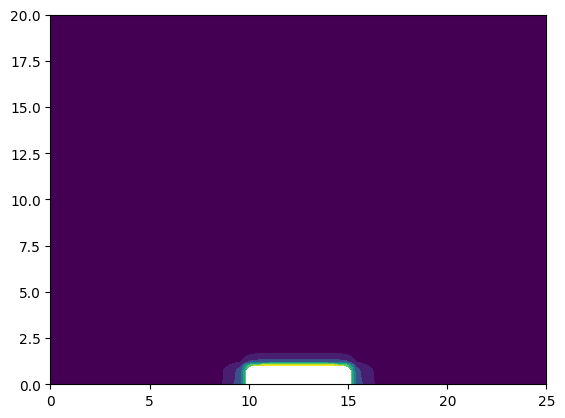

In [463]:
solver_1 = SimpleIdealSolver()
solver_1.solve(50, name="T")

  0%|          | 0/100 [00:00<?, ?it/s]/var/folders/j4/hzzk71yx5n14s5jzcccjgr2m0000gn/T/ipykernel_63526/660549609.py:33: RuntimeWarning: invalid value encountered in divide
  content = (self.f * (self.v_grid**2).sum(axis=3)).sum(axis=(2, 3, 4)) / (3 * n)
100%|██████████| 100/100 [01:13<00:00,  1.37it/s]


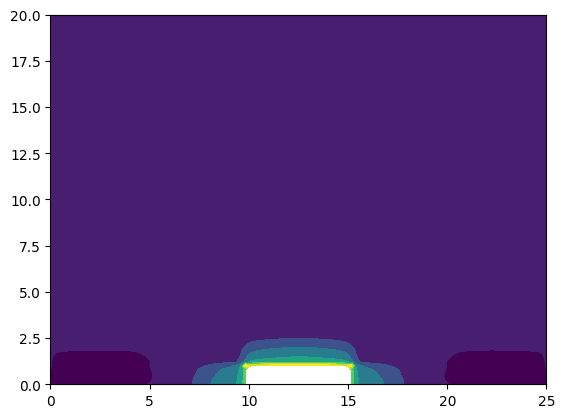

In [464]:
solver_1.solve(100, name="T")

In [466]:
print(solver_1.f.compute_T(0, 100, 2, 3))

[[1.00009088]
 [0.99872063]
 [0.99848711]
 [0.99832499]
 [0.99821221]
 [0.99813515]
 [0.99808364]
 [0.99805011]
 [0.99802894]
 [0.99801616]
 [0.99800919]
 [0.99800669]
 [0.99800871]
 [0.99801703]
 [0.99803601]
 [0.99807414]
 [0.99814644]
 [0.99827788]
 [0.99850809]
 [0.99889704]
 [0.99953133]
 [1.00052994]
 [1.00204782]
 [1.00427472]
 [1.00742607]
 [1.01172239]
 [1.01735428]
 [1.02443284]
 [1.03293048]
 [1.04262567]
 [1.05307517]
 [1.06364409]
 [1.0736219 ]
 [1.0824309 ]
 [1.0898828 ]
 [1.09639935]
 [1.10331399]
 [1.11372112]
 [1.13132291]
 [1.19530962]
 [       nan]
 [       nan]
 [       nan]
 [       nan]
 [       nan]
 [       nan]
 [       nan]
 [       nan]
 [       nan]
 [       nan]
 [       nan]
 [       nan]
 [       nan]
 [       nan]
 [       nan]
 [       nan]
 [       nan]
 [       nan]
 [       nan]
 [       nan]
 [1.19219051]
 [1.12663416]
 [1.10833523]
 [1.09778661]
 [1.09110557]
 [1.08507482]
 [1.07826339]
 [1.07016069]
 [1.06088133]
 [1.05095016]
 [1.04104687]
 [1.03

/var/folders/j4/hzzk71yx5n14s5jzcccjgr2m0000gn/T/ipykernel_63526/660549609.py:45: RuntimeWarning: invalid value encountered in divide
  return ((self.f * (self.v_grid**2).sum(axis=3)).sum(axis=(2, 3, 4)) / 3)[x_start:x_stop, y_start:y_stop] / n


In [419]:
print(solver_1.f.compute_T(58, 100, 3, 4))

[[       nan]
 [       nan]
 [1.17285358]
 [1.11518499]
 [1.09485524]
 [1.083276  ]
 [1.07596188]
 [1.06997928]
 [1.06388305]
 [1.05699637]
 [1.04923422]
 [1.04094196]
 [1.03266841]
 [1.02496067]
 [1.01823085]
 [1.01270231]
 [1.00841813]
 [1.00528458]
 [1.003125  ]
 [1.00172833]
 [1.00088589]
 [1.00041561]
 [1.00017466]
 [1.00006212]
 [1.0000139 ]
 [0.99999338]
 [0.99998116]
 [0.9999666 ]
 [0.99994208]
 [0.9998997 ]
 [0.99983003]
 [0.99972249]
 [0.99956734]
 [0.99935932]
 [0.99910241]
 [0.99881463]
 [0.99853046]
 [0.99829829]
 [0.99817046]
 [0.99818833]
 [0.99837375]
 [1.00009088]]


/var/folders/j4/hzzk71yx5n14s5jzcccjgr2m0000gn/T/ipykernel_63526/2668441589.py:45: RuntimeWarning: invalid value encountered in divide
  return ((self.f * (self.v_grid**2).sum(axis=3)).sum(axis=(2, 3, 4)) / 3)[x_start:x_stop, y_start:y_stop] / n


In [407]:
print(solver_1.f.compute_T(55, 56, 3, 20))

[[       nan 1.44649925 1.25498855 1.23766025 1.20641485 1.16402105
  1.11844396 1.07773253 1.04648141 1.02539831 1.0127045  1.00581746
  1.00243338 1.00092507 1.00031577 1.00009321 1.00001995]]


/var/folders/j4/hzzk71yx5n14s5jzcccjgr2m0000gn/T/ipykernel_63526/2668441589.py:45: RuntimeWarning: invalid value encountered in divide
  return ((self.f * (self.v_grid**2).sum(axis=3)).sum(axis=(2, 3, 4)) / 3)[x_start:x_stop, y_start:y_stop] / n


In [367]:
print(solver_1.f.compute_T(35, 45, 3, 4))

[[1.05248548]
 [1.08365896]
 [1.11041723]
 [1.10326008]
 [1.04189436]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]]


In [368]:
print(solver_1.f.compute_T(35, 36, 0, 20))

[[1.07473261 1.06633599 1.05918888 1.05248548 1.03610855 1.01791897
  1.01073298 1.00587775 1.00293347 1.00133737 1.00055721 1.00021051
  1.00006958 1.00001697 0.99999889 0.99999316 0.99999149 0.99999103
  0.99999092 0.9999909 ]]
